In [1]:
# this is an example for a naive bayes sentiment analyzer from the book "Natural Language Processing in Action" by Lane, Howard and Hapke.
# i only added a few more comments and made it work without installing the NLPIA package.

import pandas as pd
from nltk.tokenize import casual_tokenize
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, plot_confusion_matrix

# read in the text file 
movies = pd.read_csv('movieReviewSnippets_GroundTruth.txt', sep='\t', index_col=0, names=['sentiment', 'text'] )

In [2]:
# lets take a quick look at our data
movies.describe()
movies.head()

,sentiment,text
1,2.266667,The Rock is destined to be the 21st Century's ...
2,3.533333,The gorgeously elaborate continuation of ''The...
3,-0.600000,Effective but too tepid biopic
4,1.466667,If you sometimes like to go to the movies to h...
5,1.733333,"Emerges as something rare, an issue movie that..."


In [3]:
# the reviews are rated from -4 to 4

# let's convert them into the bag-of-words representation

bags_of_words = []
for text in movies.text:
    bags_of_words.append(Counter(casual_tokenize(text))) # Counter creates a dict with token: count of token

# lets create a Dataframe of bows
df_bows = pd.DataFrame.from_records(bags_of_words)
# fill all NaN with zero so we can convert them to int
df_bows = df_bows.fillna(0).astype(int)

# lets see how large our bow table has become
df_bows.shape



(10605, 20756)

In [4]:
# the 10605 reviews include 20756 different tokens
# what threw me off at first is: the bag-of-words conversion via the Counter returns dense representations - only actually present tokens are included in the bow representation of a single review.
# these become sparse by creating the dataframe - from_records creates one column per unique key in the list of bow representations and fills each column with missing values with NaN (which we then replaced by 0).

In [5]:
# lets start with the model itself

nb = MultinomialNB()

# split the dataset into training and validation set
train_x, val_x, train_y, val_y = train_test_split(df_bows, movies.sentiment, random_state=1)

nb = nb.fit(train_x, train_y > 0) # convert the train_y to a boolean value


# training MAE
train_predictions = nb.predict(train_x)
training_mae = mean_absolute_error(train_predictions * 8 - 4, train_y)
print(training_mae)

# predict the validation set
val_predictions = nb.predict(val_x) 
# calculate MAE for the validation data set
val_mae = mean_absolute_error(val_predictions * 8 - 4, val_y)
print(val_mae)


# now lets predict the whole dataset and add the prediction to the dataframe.
movies['predicted_sentiment'] = nb.predict(df_bows) * 8 - 4 #convert binary classification to -4 or 4 for comparison.

complete_mae = mean_absolute_error(movies['predicted_sentiment'], movies.sentiment)
print(complete_mae)
movies['error'] = (movies.predicted_sentiment - movies.sentiment).abs()


# as we can see, the authors of the book were correct: one should split training and validation sets. 
# the MAE is much larger for the predictions on the validation data set.
# the MAE is in this case potentially not the best metric - we built a classifier.


2.3643192939004942
2.878633376550765
2.4929341875533484


In [6]:
movies['sentiment_ispositive'] = (movies.sentiment > 0 ).astype(int)
movies['predicted_ispositive'] = (movies.predicted_sentiment > 0 ).astype(int)
movies['sentiment predicted_sentiment sentiment_ispositive predicted_ispositive'.split()].head(8)

,sentiment,predicted_sentiment,sentiment_ispositive,predicted_ispositive
1,2.266667,4,1,1
2,3.533333,4,1,1
3,-0.600000,-4,0,0
4,1.466667,4,1,1
5,1.733333,4,1,1
6,2.533333,4,1,1
7,2.466667,4,1,1
8,1.266667,-4,1,0


In [7]:
print((movies.predicted_ispositive == movies.sentiment_ispositive).sum() / len(movies))
# training set only
print((train_predictions == (train_y > 0)).sum() / len(train_predictions))

# same calculation for the validation set only:
print((val_predictions == (val_y > 0)).sum() / len(val_predictions))

0.902970297029703
0.9454293977115554
0.7756410256410257


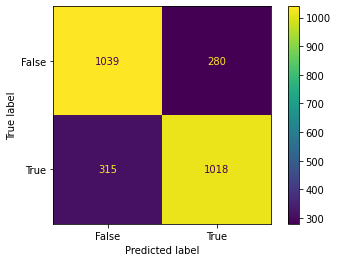

In [8]:
# that means we get roughly 78 % of the labels correct in the validation data set
# instead of 90 % in the case of the complete dataset or 95 % on the training set.
# next we should have a look at a confusion matrix.

plot_confusion_matrix(nb, val_x, val_y > 0)


In [9]:
# lets see how our model performs on a different dataset
products = pd.read_csv('amazonReviewSnippets_GroundTruth.txt', sep='\t', index_col=0, names=['sentiment', 'text'] )

bags_of_words = []
# we convert these reviews to BoW in the same way as the movie reviews
for text in products.text:
    bags_of_words.append(Counter(casual_tokenize(text)))
df_product_bows = pd.DataFrame.from_records(bags_of_words)

df_product_bows = df_product_bows.fillna(0).astype(int)
df_all_bows = df_bows.append(df_product_bows)
df_all_bows.columns
# we now have more columns - this corresponds to more tokens in the product reviews than in the movie reviews


Index(['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century's',
       'new',
       ...
       'sligtly', 'owner', '81', 'defectively', 'warrranty', 'expire',
       'expired', 'voids', 'baghdad', 'harddisk'],
      dtype='object', length=23302)

In [10]:
df_product_bows = df_all_bows.iloc[len(movies):][df_bows.columns]
# we need to fill the NaN again that stem from the tokens available in the movie reviews, but not the product reviews.
df_product_bows = df_product_bows.fillna(0).astype(int)
print(df_product_bows.head())
products['ispos'] = (products.sentiment > 0).astype(int)
products['predicted_ispositive'] = nb.predict(df_product_bows.values).astype(int)


   The  Rock  is  destined  to  be  the  21st  Century's  new  ...  Ill  \
0    0     0   0         0   0   0    0     0          0    0  ...    0   
1    0     0   0         0   0   0    0     0          0    0  ...    0   
2    0     0   0         0   0   0    0     0          0    0  ...    0   
3    0     0   0         0   0   0    0     0          0    0  ...    0   
4    0     0   0         0   1   0    2     0          0    0  ...    0   

   slummer  Rashomon  dipsticks  Bearable  Staggeringly  ’  ve  muttering  \
0        0         0          0         0             0  0   0          0   
1        0         0          0         0             0  0   0          0   
2        0         0          0         0             0  0   0          0   
3        0         0          0         0             0  0   0          0   
4        0         0          0         0             0  0   0          0   

   dissing  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows

In [11]:
(products.predicted_ispositive == products.ispos).sum() / len(products)

0.5547095318668923